In [1]:
import os, pickle, csv, copy, itertools, datetime
import tqdm

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers

from keras_tqdm import TQDMNotebookCallback
import tensorflow_addons as tfa
from kerastuner.tuners import RandomSearch

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# %load_ext tensorboard

In [2]:
# print(tf.__version__)
# tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )

In [3]:
# %reload_ext tensorboard

# CNN models

In [4]:
file = open('trainTestIO', 'rb')
X_train_IO, X_test_IO, y_train_IO, y_test_IO = pickle.load(file)
file.close()

file = open('trainTestVR', 'rb')
X_train_VR, X_test_VR, y_train_VR, y_test_VR = pickle.load(file)
file.close()

file = open('trainTestVV', 'rb')
X_train_VV, X_test_VV, y_train_VV, y_test_VV = pickle.load(file)
file.close()

In [5]:
X_train_IO = np.reshape(X_train_IO, (X_train_IO.shape[0], X_train_IO.shape[1], 1))
X_test_IO = np.reshape(X_test_IO, (X_test_IO.shape[0], X_test_IO.shape[1], 1))

X_train_VR = np.reshape(X_train_VR, (X_train_VR.shape[0], X_train_VR.shape[1], 1))
X_test_VR = np.reshape(X_test_VR, (X_test_VR.shape[0], X_test_VR.shape[1], 1))

X_train_VV = np.reshape(X_train_VV, (X_train_VV.shape[0], X_train_VV.shape[1], 1))
X_test_VV = np.reshape(X_test_VV, (X_test_VV.shape[0], X_test_VV.shape[1], 1))

In [6]:
X_train_IO.shape, y_train_IO.shape, X_test_IO.shape, y_test_IO.shape

((3877, 250, 1), (3877,), (1911, 250, 1), (1911,))

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model = keras.Sequential()
model.add(layers.Conv1D(128, 50, strides=1, padding='valid', activation='relu', input_shape=(250,1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',               
    metrics=['accuracy'])
model.fit(X_train_IO, y_train_IO, validation_data=(X_test_IO, y_test_IO), 
          epochs=10, batch_size=512, verbose=1, shuffle=True, 
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/10
8/8 [==============================] - 2s 200ms/step - loss: 0.7019 - accuracy: 0.4898 - val_loss: 0.6884 - val_accuracy: 0.4950
Epoch 2/10
8/8 [==============================] - 1s 129ms/step - loss: 0.6842 - accuracy: 0.5539 - val_loss: 0.6652 - val_accuracy: 0.9304
Epoch 3/10
8/8 [==============================] - 1s 130ms/step - loss: 0.6528 - accuracy: 0.7620 - val_loss: 0.6167 - val_accuracy: 0.6238
Epoch 4/10
8/8 [==============================] - 1s 122ms/step - loss: 0.5895 - accuracy: 0.7436 - val_loss: 0.5178 - val_accuracy: 0.8713
Epoch 5/10
8/8 [==============================] - 1s 120ms/step - loss: 0.4805 - accuracy: 0.8933 - val_loss: 0.4086 - val_accuracy: 0.8702
Epoch 6/10
8/8 [==============================] - 1s 135ms/step - loss: 0.3820 - accuracy: 0.8887 - val_loss: 0.3250 - val_accuracy: 0.9016
Epoch 7/10
8/8 [==============================] - 1s 141ms/step - loss: 0.3045 - accuracy: 0.9091 - val_loss: 0.2762 - val_accuracy: 0.9534
Epoch 8/10
8/8 [====

In [15]:
def buid_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(hp.Int('conv_filters_1', min_value=2, max_value=200, step=64), hp.Int('conv_ksize_1', min_value=32, max_value=225, step=32), strides=1, padding='valid', activation='relu', input_shape=(250,1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_filters_1', min_value=2, max_value=200, step=2), activation='relu'))
    model.add(layers.Dense(hp.Int('dense_filters_2', min_value=2, max_value=200, step=2), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',               
        metrics=['accuracy'])
    return model

# Tuner Search

In [16]:
tuner = RandomSearch(buid_model, objective='val_accuracy', max_trials=500, executions_per_trial=5, directory='trial_1', project_name='name')

In [17]:
tuner.search(x=X_train_IO, y=y_train_IO,
             epochs=25, batch_size=128,
             validation_data=(X_test_IO, y_test_IO))

Trial 500 Complete [00h 00m 15s]
val_accuracy: 0.884353756904602

Best val_accuracy So Far: 0.9854526400566102
Total elapsed time: 02h 39m 18s
INFO:tensorflow:Oracle triggered exit


In [18]:
tuner.results_summary()

Results summary
Results in trial_1\name
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_filters_1: 130
conv_ksize_1: 32
dense_filters_1: 152
dense_filters_2: 150
Score: 0.9854526400566102
Trial summary
Hyperparameters:
conv_filters_1: 66
conv_ksize_1: 32
dense_filters_1: 170
dense_filters_2: 162
Score: 0.9848247051239014
Trial summary
Hyperparameters:
conv_filters_1: 130
conv_ksize_1: 32
dense_filters_1: 94
dense_filters_2: 196
Score: 0.9848246932029724
Trial summary
Hyperparameters:
conv_filters_1: 66
conv_ksize_1: 32
dense_filters_1: 172
dense_filters_2: 172
Score: 0.9848246932029724
Trial summary
Hyperparameters:
conv_filters_1: 130
conv_ksize_1: 32
dense_filters_1: 136
dense_filters_2: 130
Score: 0.9846153974533081
Trial summary
Hyperparameters:
conv_filters_1: 194
conv_ksize_1: 32
dense_filters_1: 166
dense_filters_2: 54
Score: 0.9846153855323792
Trial summary
Hyperparameters:
conv_filters_1: 2
conv_ksize_1: 96
dense_filte

In [ ]:
best_model = tuner.get_best_models(num_models=2)[0]

In [45]:
best_model.evaluate(X_test_IO, y_test_IO)

60/60 [==============================] - 0s 1ms/step - loss: 0.0606 - accuracy: 0.9869


[0.060593586415052414, 0.9869178533554077]

In [46]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 219, 130)          4290      
_________________________________________________________________
flatten (Flatten)            (None, 28470)             0         
_________________________________________________________________
dense (Dense)                (None, 152)               4327592   
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22950     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 4,354,983
Trainable params: 4,354,983
Non-trainable params: 0
_________________________________________________________________


In [47]:
best_model.save('modelo_9869.h5')

In [ ]:
best_model2 = tuner.get_best_models(num_models=3)[1]

In [49]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 219, 66)           2178      
_________________________________________________________________
flatten (Flatten)            (None, 14454)             0         
_________________________________________________________________
dense (Dense)                (None, 170)               2457350   
_________________________________________________________________
dense_1 (Dense)              (None, 162)               27702     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 163       
Total params: 2,487,393
Trainable params: 2,487,393
Non-trainable params: 0
_________________________________________________________________


In [41]:
best_model2.evaluate(X_test_IO, y_test_IO)

60/60 [==============================] - 0s 1ms/step - loss: 0.0560 - accuracy: 0.9869


[0.05598752945661545, 0.9869178533554077]

In [50]:
best_model2.save('modelo_9869_2.h5')

In [ ]:
best_model3 = tuner.get_best_models(num_models=3)[2]

In [52]:
best_model3.evaluate(X_test_IO, y_test_IO)

60/60 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9864


[0.058036405593156815, 0.9863945841789246]

In [53]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 219, 66)           2178      
_________________________________________________________________
flatten (Flatten)            (None, 14454)             0         
_________________________________________________________________
dense (Dense)                (None, 170)               2457350   
_________________________________________________________________
dense_1 (Dense)              (None, 162)               27702     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 163       
Total params: 2,487,393
Trainable params: 2,487,393
Non-trainable params: 0
_________________________________________________________________


In [54]:
best_model3.save('modelo_9864.h5')

# Results analysis

In [29]:
model = tf.keras.models.load_model('modelo_9869.h5')

In [35]:
model.evaluate(X_test_IO, y_test_IO)

60/60 [==============================] - ETA: 1s - loss: 0.0136 - accuracy: 1.00 - ETA: 0s - loss: 0.0497 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accuracy: 0.99 - ETA: 0s - loss: 0.0505 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accuracy: 0.99 - ETA: 0s - loss: 0.0492 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0493 - accuracy: 0.9895


[0.04929758980870247, 0.9895342588424683]

In [31]:
y_pred = model.predict(X_test_IO)

In [32]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Parameters
    ----------
    cm : numpy ndarray with 
        matrix with the confusion matrix values returned from scipy
    normalize : Boolen
        wether cm is normalized or not
    title: string
        plot title text
    cmap: string
        matplotlib plt.cm cmap options
        
    Returns
    -------
        None
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[953  13]
 [  8 937]]
regular 	 0.9865424430641822 %
blink 	 0.9915343915343915 %


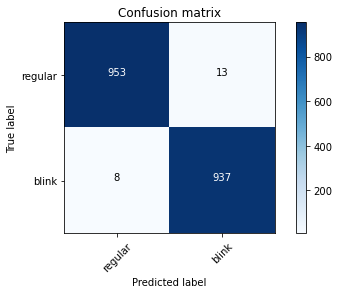

In [26]:
labels_resultado = ['regular', 'blink']
cm = confusion_matrix(y_test_IO, y_pred.round())
plot_confusion_matrix(cm, labels_resultado)
for i in range(2):
    print(f'{labels_resultado[i]} \t {cm[i,i]/cm[i,:].sum()} %')

In [27]:
Tp = cm[1,1]
Tn = cm[0,0]
Fp = cm[0,1]
Fn = cm[1,0]
prec = (Tp)/(Tp + Fp)
rec = (Tp)/(Tp + Fn)

In [28]:
print(f'Accuracy  =  {100*(Tp + Tn)/(Tp+Tn+Fp+Fn)}%')
print(f'Precision =  {100*(Tp)/(Tp + Fp)} %')
print(f'Recal     =  {100*(Tp)/(Tp + Fn)} %')
print(f'F1 Rate   =  {100*2*(prec*rec)/(prec + rec)}')

Accuracy  =  98.9010989010989%
Precision =  98.63157894736842 %
Recal     =  99.15343915343915 %
F1 Rate   =  98.89182058047494


In [29]:
report = classification_report(y_test_IO, y_pred.round(), digits=4)
print(report)

              precision    recall  f1-score   support

         0.0     0.9917    0.9865    0.9891       966
         1.0     0.9863    0.9915    0.9889       945

    accuracy                         0.9890      1911
   macro avg     0.9890    0.9890    0.9890      1911
weighted avg     0.9890    0.9890    0.9890      1911

